<a href="https://colab.research.google.com/github/dgutiluns/water-anomaly-ca/blob/main/element_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#from google.colab import files

# CKAN API endpoint
url = "https://data.ca.gov/api/3/action/datastore_search"

# Parameters for the request
params = {
    "resource_id": "e07c5e0b-cace-4b70-9f13-b3e696cd5a99",
    "limit": 100000  # number of rows to fetch (can adjust as needed)
}

In [2]:
response = requests.get(url, params=params)
data = response.json()

# Preview total records and first rows
print("Total records available:", data["result"]["total"])
print("First row:", data["result"]["records"][0])

# Extract the records and convert to DataFrame
records = data["result"]["records"]
df = pd.DataFrame.from_records(records)

Total records available: 1777955
First row: {'_id': 1, 'Program': 'Proposition 84', 'ParentProject': 'Prop84-City of San Diego', 'Project': 'City of San Diego Hypolimnetic Oxygenation System', 'StationName': 'HGA', 'StationCode': 'HGA', 'SampleDate': '2017-04-18T00:00:00', 'CollectionTime': '00:00', 'LocationCode': 'Not Recorded', 'CollectionDepth': 0, 'UnitCollectionDepth': 'm', 'SampleTypeCode': 'Field_Grab', 'CollectionReplicate': 1, 'ResultsReplicate': 1, 'LabBatch': 'UCMercedEAL_20170418_NO3NO2', 'LabSampleID': 'NA', 'MatrixName': 'samplewater', 'MethodName': 'EPA 353.2', 'Analyte': 'Nitrate + Nitrite as N, Total', 'Unit': 'mg/L', 'Result': None, 'Observation': 'NA', 'MDL': 0.05, 'RL': -88, 'ResultQualCode': 'ND', 'QACode': 'None', 'BatchVerification': 'NR', 'ComplianceCode': 'NR', 'SampleComments': 'NA', 'CollectionComments': 'NA', 'ResultsComments': 'NA', 'BatchComments': 'NA', 'EventCode': 'WQ', 'ProtocolCode': 'Not Applicable', 'SampleAgency': 'UC Merced EAL', 'GroupSamples': 

In [3]:
import numpy as np
import pandas as pd

# Work on a deep copy so the original df stays intact
df_proc = df.copy(deep=True)

# 1) Coerce numeric on the copy
num_cols = ["Result","RL","MDL","DilutionFactor","Latitude","Longitude"]
for c in num_cols:
    if c in df_proc.columns:
        df_proc[c] = pd.to_numeric(df_proc[c], errors="coerce")

# 2) Fill censored values (Result -> RL -> MDL)
mask_empty  = df_proc["Result"].isna()
mask_rl_bad = df_proc["RL"].isna() | (df_proc["RL"] < 0)

df_proc["Result_filled"] = df_proc["Result"]
df_proc.loc[mask_empty & ~mask_rl_bad, "Result_filled"] = df_proc.loc[mask_empty & ~mask_rl_bad, "RL"]
df_proc.loc[mask_empty &  mask_rl_bad, "Result_filled"] = df_proc.loc[mask_empty &  mask_rl_bad, "MDL"]

# Audit flag
df_proc["SubbedFrom"] = np.where(mask_empty & ~mask_rl_bad, "RL",
                         np.where(mask_empty & mask_rl_bad, "MDL", "Result"))

# 3) Normalize units to µg/L
def to_ugL(val, unit):
    if pd.isna(val): return np.nan
    u = (str(unit) if unit is not None else "").strip().lower()
    if u in ["µg/l","ug/l","micrograms per liter","microgram per liter"]:
        return float(val)
    if u in ["mg/l","milligrams per liter","milligram per liter"]:
        return float(val) * 1000.0
    if u in ["ng/l","nanograms per liter","nanogram per liter"]:
        return float(val) * 0.001
    # Unknown → pass through
    return float(val)

df_proc["Result_ugL"] = [to_ugL(v, u) for v, u in zip(df_proc["Result_filled"], df_proc.get("Unit", np.nan))]

# 4) Keep only “Total” analytes **in a second copy**
df_total = df_proc.loc[df_proc["Analyte"].str.contains("Total", case=False, na=False)].copy()


In [4]:
# Remove trailing ", Total" (case-insensitive) and strip whitespace
mask = df_total["Analyte"].str.contains(r",\s*Total$", na=False)
print("Rows ending with ', Total':", mask.sum())

df_total["Analyte"] = df_total["Analyte"].str.replace(r",\s*Total$", "", regex=True)
df_total["Analyte"] = df_total["Analyte"].str.strip()

# Grouped stats over Result_ugL
grp = df_total.groupby("Analyte", dropna=False)["Result_ugL"]

summary = pd.DataFrame({
    "n_samples": grp.size(),
    "mean": grp.mean(),
    "std": grp.std(),
    "min": grp.min(),
    "q25": grp.quantile(0.25),
    "median": grp.median(),
    "q75": grp.quantile(0.75),
    "max": grp.max(),
}).reset_index()

display(summary.head(5))

# How many rows used RL/MDL per analyte
subs = (
    df_total[df_total["SubbedFrom"].isin(["RL","MDL"])]
      .groupby(["Analyte","SubbedFrom"]).size()
      .unstack(fill_value=0)
      .reset_index()
)

summary = summary.merge(subs, on="Analyte", how="left").fillna({"MDL": 0, "RL": 0})
display(summary.head(5))


Rows ending with ', Total': 36065


,Analyte,n_samples,mean,std,min,q25,median,q75,max
0,Acenaphthene,210,0.382474,2.151872,0.0013,0.005,0.005,0.050,17.000
1,Acenaphthene-d10(Surrogate),103,79.796117,17.901341,43.0000,68.000,76.000,91.500,118.000
2,Acenaphthylene,210,0.391987,2.153840,0.0010,0.005,0.005,0.050,17.000
3,Acetaminophen,1,0.005000,NaN,0.0050,0.005,0.005,0.005,0.005
4,Acetamiprid,41,0.036276,0.075753,0.0116,0.020,0.020,0.020,0.496


,Analyte,n_samples,mean,std,min,q25,median,q75,max,MDL,RL
0,Acenaphthene,210,0.382474,2.151872,0.0013,0.005,0.005,0.050,17.000,0.0,195.0
1,Acenaphthene-d10(Surrogate),103,79.796117,17.901341,43.0000,68.000,76.000,91.500,118.000,0.0,0.0
2,Acenaphthylene,210,0.391987,2.153840,0.0010,0.005,0.005,0.050,17.000,0.0,179.0
3,Acetaminophen,1,0.005000,NaN,0.0050,0.005,0.005,0.005,0.005,0.0,1.0
4,Acetamiprid,41,0.036276,0.075753,0.0116,0.020,0.020,0.020,0.496,0.0,30.0


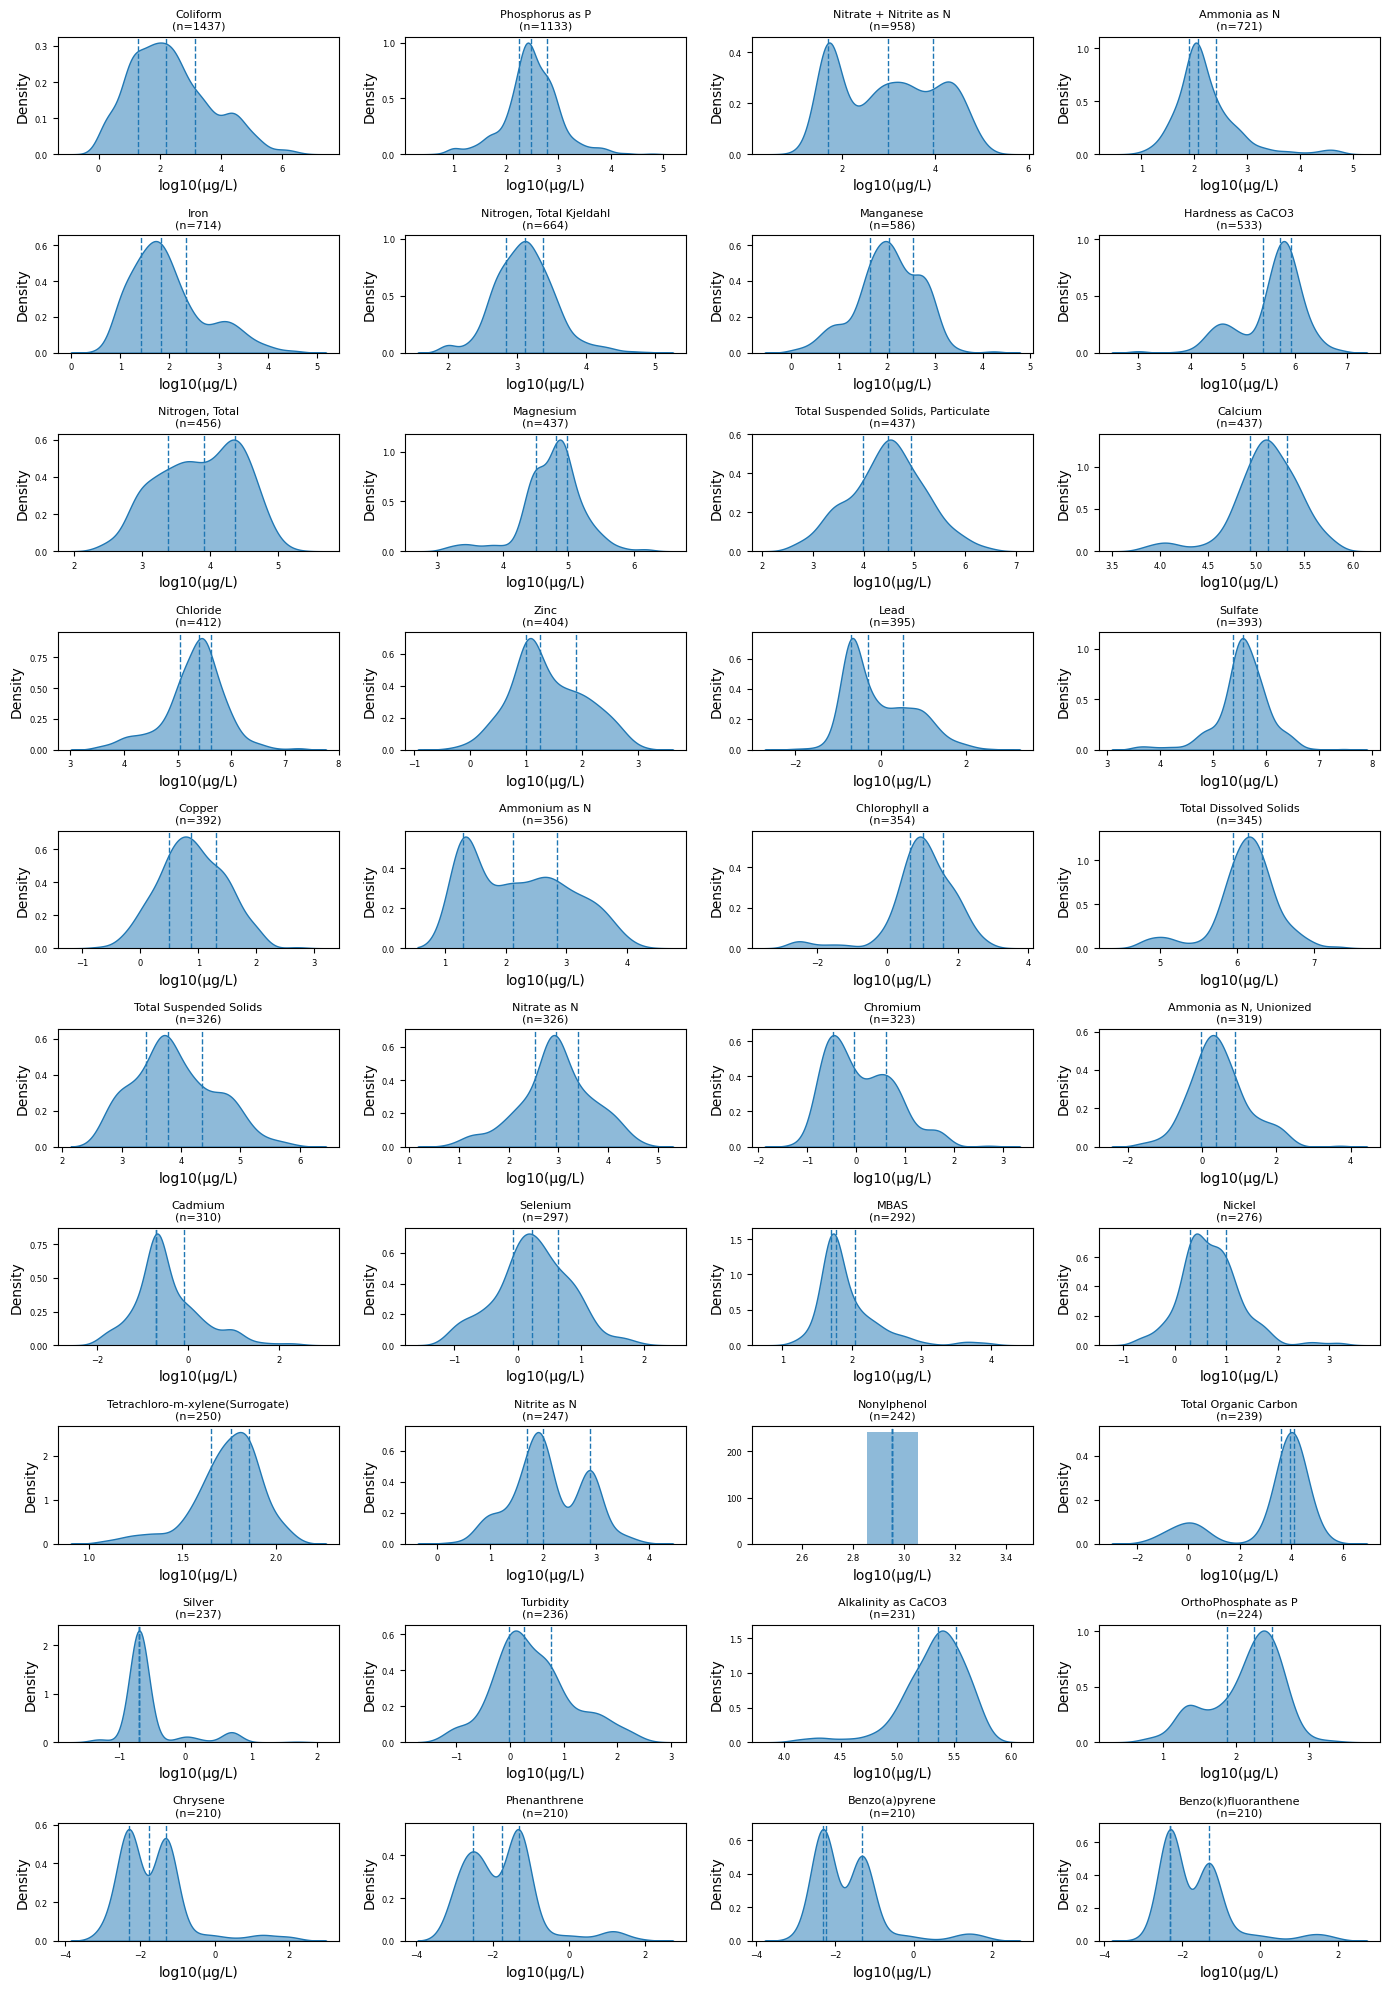

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top40 = summary.sort_values("n_samples", ascending=False).head(40)["Analyte"]

plt.figure(figsize=(14, 20))
for i, chem in enumerate(top40, 1):
    plt.subplot(10, 4, i)
    x = df_total.loc[df_total["Analyte"] == chem, "Result_ugL"].dropna()
    x = x[x > 0]  # avoid log of non-positive
    if x.nunique() > 1:
        sns.kdeplot(np.log10(x), fill=True, alpha=0.5, linewidth=1)
    else:
        plt.hist(np.log10(x) if len(x) else x, bins=5, alpha=0.5)

    row = summary.loc[summary["Analyte"] == chem].iloc[0]
    for q in ["q25","median","q75"]:
        v = row[q]
        if pd.notna(v) and v > 0:
            plt.axvline(np.log10(v), linestyle="--", linewidth=1)

    plt.title(f"{chem}\n(n={int(row['n_samples'])})", fontsize=8)
    plt.xlabel("log10(µg/L)")
    plt.xticks(fontsize=6); plt.yticks(fontsize=6)

plt.tight_layout(); plt.show()
